In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from copy import deepcopy
from lifelines.statistics import logrank_test
%config InlineBackend.figure_format = 'retina'
import numpy as np
import seaborn as sns
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from scipy.stats import pearsonr
import sys
import warnings
from collections import Counter
from statannot import add_stat_annotation
from statsmodels.stats.multitest import multipletests
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load MSK data

In [5]:
# read sample meta data and eliminate samples without transplant day
df_sample = pd.read_csv('tblASVsamples.csv', index_col=0)
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read count data
df_count_stacked = pd.read_csv('tblcounts_asv_melt.csv')
df_count_stacked = pd.pivot_table(df_count_stacked, index='SampleID', columns='ASV', values='Count', aggfunc=np.sum).fillna(0)
df_count_stacked = df_count_stacked[df_count_stacked.sum(axis=1)>=1000]
print("min seq depth = %d" %(df_count_stacked.sum(axis=1).min()))
df_relab =  df_count_stacked.div(df_count_stacked.sum(axis=1), axis=0)

# find commmon samples
common_samples = set(df_sample.index).intersection(set(df_relab.index))
df_sample = df_sample.loc[common_samples]
df_relab = df_relab.loc[common_samples]

# get oral ASVs
df_blast_100 = pd.read_csv("blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#

min seq depth = 1001


# Read drug exposure

In [6]:
# read drug administration records
df_drug = pd.read_csv('tbldrug.csv')
df_drug = df_drug[df_drug.AntiInfective==True].reset_index(drop=True)

# convert to single day entry
df_drug_single_day = []
for index in df_drug.index:
    start_tps = df_drug.loc[index,'StartTimepoint']
    stop_tps = df_drug.loc[index,'StopTimepoint']
    start_day = df_drug.loc[index,'StartDayRelativeToNearestHCT']
    for timepoint in np.arange(start_tps,stop_tps+1):
        res = list(df_drug.loc[index])
        res.append(timepoint)
        res.append(timepoint-start_tps+start_day)
        df_drug_single_day.append(res)
df_drug_single_day = pd.DataFrame(df_drug_single_day, columns=list(df_drug.columns)+['Timepoint','DayRelativeToNearestHCT'])
df_drug_single_day = df_drug_single_day.drop(['StartTimepoint','StopTimepoint','StartDayRelativeToNearestHCT','StopDayRelativeToNearestHCT'], axis=1)
df_drug = deepcopy(df_drug_single_day)
df_drug = df_drug[df_drug.DayRelativeToNearestHCT.notnull()]
df_drug = df_drug.drop_duplicates()

# only keep antibiotics
df_drug = df_drug[df_drug.Category.isin(['aminoglycosides','carbapenems','cephalosporins','glycopeptide antibiotics','glycylcyclines',
                                         'leprostatics','lincomycin derivatives','macrolide derivatives','miscellaneous antibiotics',
                                         'oxazolidinone antibiotics', 'penicillins','quinolones','sulfonamides','tetracyclines'])]

# restructure drugs for downstream analysis
df_drug['GroupLabel'] = 'other'

# change vancomycin to oral vanco and iv vanco
df_drug.loc[(df_drug.Factor=='vancomycin')&(df_drug.Route=='oral'), 'GroupLabel'] = 'vancomycin_oral'
df_drug.loc[(df_drug.Factor=='vancomycin')&(df_drug.Route=='intravenous'), 'GroupLabel'] = 'vancomycin_iv'

# change sulfamethoxazole trimethoprim to sulfamethoxazole/trimethoprim
df_drug.loc[df_drug.Factor=='sulfamethoxazole trimethoprim', 'Factor'] = 'sulfamethoxazole/trimethoprim'

# set the following factors as independent groups
for f in ['amoxicillin clavulanate','piperacillin/tazobactam','metronidazole','clindamycin',
          'tigecycline','linezolid','sulfamethoxazole/trimethoprim','doxycycline','aztreonam']:
    df_drug.loc[df_drug.Factor==f, 'GroupLabel'] = f
    
# set the following categories as independent groups
for c in ['carbapenems','aminoglycosides','cephalosporins','macrolide derivatives','quinolones']:
    df_drug.loc[df_drug.Category==c, 'GroupLabel'] = c

# select relevant columns
df_drug = df_drug[['PatientID','GroupLabel','DayRelativeToNearestHCT','Timepoint']]

# print unique drug groups
class2include = list(set(df_drug.GroupLabel))

df_drug.head()

,PatientID,GroupLabel,DayRelativeToNearestHCT,Timepoint
0,1000,quinolones,-169,-160
2,1000,aztreonam,-160,-151
3,1000,vancomycin_iv,-160,-151
4,1000,aztreonam,-159,-150
6,1000,vancomycin_iv,-159,-150


# Plot number of patients on antibiotics

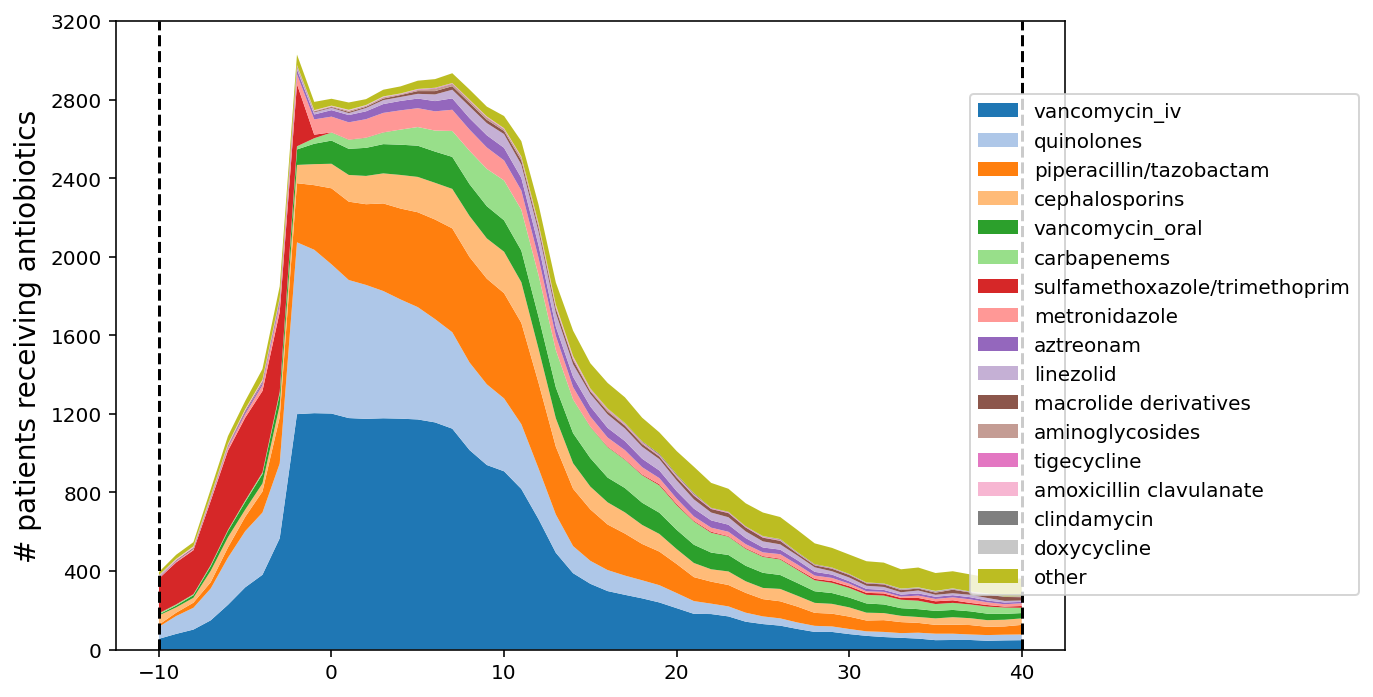

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharex=True)

#### upper panel ####

# calculate the number of patients on each day receiving antibiotics
df_drug_usage = deepcopy(df_drug)
df_drug_usage['PatientID'] = 1
df_drug_usage = df_drug_usage[(df_drug_usage.DayRelativeToNearestHCT>=-10) & (df_drug_usage.DayRelativeToNearestHCT<=40)]
df_drug_usage = df_drug_usage.groupby(['GroupLabel','DayRelativeToNearestHCT']).agg(sum).reset_index()
df_drug_usage = pd.pivot_table(df_drug_usage, values='PatientID', index='DayRelativeToNearestHCT', columns='GroupLabel').fillna(0)

# sort drug categories based on the mean number of patients receiving the drugs
df_drug_usage_T = df_drug_usage.T
df_drug_usage_T['mean'] = df_drug_usage_T.mean(axis=1)
df_drug_usage_T = df_drug_usage_T.sort_values(by=['mean'],axis=0,ascending=False)
df_drug_usage_T = df_drug_usage_T.drop('mean', axis=1)
df_drug_usage = df_drug_usage_T.T

# move other to the last column
df_drug_usage = df_drug_usage.drop(columns=['other']).assign(other=df_drug_usage['other'])

# plot fraction of patients receiving drug administration
x = list(df_drug_usage.index)
y = df_drug_usage.T.values
_ = ax.stackplot(x,y, labels=df_drug_usage.columns, colors=sns.color_palette("tab20"))
ax.legend(loc='upper right', bbox_to_anchor=(1.32, 0.9))
ax.plot([-10,-10],[0,3200],'k--')
ax.plot([40,40],[0,3200],'k--')
#_ = ax.set_xlim([-30,60])
_ = ax.set_ylim([0,3200])
_ = ax.set_yticks([0,400,800,1200,1600,2000,2400,2800,3200])
_ = ax.set_ylabel('# patients receiving antiobiotics', fontsize=14)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("patients_on_antibiotic exposure.svg")

# Run Cox model

In [8]:
def build_cox_model_input_table(study_start_day=-10,
                                study_stop_day=40,
                                min_samples_per_patient=2,
                                min_abx_exposure_times=10,
                                memory_duration = 0 # note: this is the memory effect of the drug!
                                ):
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue
        
        # check if the patient receives multiple HCT
        # treat each transplant as individual
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                #print(first_sample_day, last_sample_day)
                assert first_sample_day < last_sample_day

            # find first oral domination (use timepoint to filter)
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.index), set(df_blast_100.query_accver).intersection(df_relab.columns)]>=0.3
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any oral ASV)
            if len(df_relab_tmp) == 0:
                # no domination by oral bacteria detected, set first domination day as the day of the last sample (censoring time)
                # as if the patient drop out at the day of last sample
                first_oral_domination_day = last_sample_day
                oral_domination_event = 0
            else:
                oral_domination_days = list(df_sample_tmp.loc[df_sample_tmp.index.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])
                oral_domination_days = [day for day in oral_domination_days if day > first_sample_day]
                if len(oral_domination_days) == 0:
                    first_oral_domination_day = last_sample_day
                    oral_domination_event = 0
                else:
                    first_oral_domination_day = oral_domination_days[0]
                    oral_domination_event = 1
            assert first_oral_domination_day > first_sample_day
            
            # use drug administration records as covariant
            curr_df_drug = df_drug[df_drug.PatientID==pid]
            if len(curr_df_drug) >0:

                # reformat drug record table, with each row a particular day and each column a drug
                curr_df_drug['Value'] = 1
                curr_df_drug = pd.pivot_table(curr_df_drug, index='DayRelativeToNearestHCT', columns='GroupLabel', values='Value').fillna(0)
                for drug in class2include:
                    if drug not in list(curr_df_drug.columns):
                        curr_df_drug[drug] = 0
                curr_df_drug = curr_df_drug[class2include].astype(int)

                # add covariates and event status for each period
                curr_state = [0] * len(class2include)
                # use drug exposure on the first sample day as the initial states
                if first_sample_day in list(curr_df_drug.index):
                    prev_state = list(curr_df_drug.loc[first_sample_day])
                else:
                    prev_state = [0] * len(class2include)
                days_after_measurement = [0] * len(class2include)
                for day in np.arange(first_sample_day, first_oral_domination_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive

                    # get right day covariates
                    # drug_records are antibiotic exposure on the right day
                    if right_day in list(curr_df_drug.index):
                        drug_records = list(curr_df_drug.loc[right_day])
                    else:
                        drug_records = [0] * len(class2include)

                    # get current drug impact states
                    # since we consider antibiotic pharmacokinetics, antibiotic may impact microbiome over several days
                    curr_state = deepcopy(drug_records)
                    for k,r in enumerate(drug_records):
                        if drug_records[k]==1:
                            curr_state[k]=1
                            days_after_measurement[k] = 0 # reset the clock
                        else:
                            if days_after_measurement[k]>=memory_duration:
                                curr_state[k] = 0
                            else:
                                curr_state[k] = deepcopy(prev_state)[k]
                            days_after_measurement[k] += 1

                    # combine with previous records
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.extend(curr_state)
                        if right_day == first_oral_domination_day:
                            curr_line.append(oral_domination_event)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state) # must be deepcopy! otherwise, change in curr_state will lead to the same change to prev_state
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_oral_domination_day:
                            last_line[-1] = oral_domination_event
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line                        
            else:
                lines.append([pid, first_sample_day, first_oral_domination_day] + [0]*len(class2include) + [oral_domination_event])
    
    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay']+class2include+['Domination'])
    
    # remove drugs that have been used for less than 10 times
    drugs2drop = []
    for drug in df_cox.iloc[:,3:-1]:
        if np.sum(df_cox[drug]) < min_abx_exposure_times:
            drugs2drop.append(drug)
    df_cox = df_cox.drop(drugs2drop, axis=1)
        
    return df_cox

# Plot harzard ratio (no memory)

In [9]:
# build input table
df_cox_wo_mem = build_cox_model_input_table(memory_duration=0, min_samples_per_patient=5)

# run cox regression at panelty=0
ctv_wo_mem = CoxTimeVaryingFitter(penalizer=0)
ctv_wo_mem.fit(df_cox_wo_mem, id_col="PatientID", event_col="Domination", start_col="StartDay", stop_col="StopDay", show_progress=False)
df_cox_summary = ctv_wo_mem.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]

# remove drugs with insufficient data to support its correlation
df_cox_summary = df_cox_summary[df_cox_summary['exp(coef) upper 95%']!=np.inf]
df_cox_summary = df_cox_summary.drop('other')
df_cox_summary = df_cox_summary.sort_values('exp(coef)')
df_cox_summary

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p
covariate,,,,
metronidazole,0.240496,0.031217,1.852760,1.713174e-01
quinolones,0.317635,0.164887,0.611886,6.072072e-04
aztreonam,0.708352,0.164746,3.045667,6.431080e-01
vancomycin_iv,0.867307,0.526114,1.429771,5.767173e-01
linezolid,1.366531,0.412750,4.524304,6.091844e-01
carbapenems,1.479795,0.657120,3.332411,3.440474e-01
cephalosporins,1.540633,0.782396,3.033697,2.112465e-01
vancomycin_oral,1.709478,1.001720,2.917297,4.926786e-02
piperacillin/tazobactam,3.301137,2.067473,5.270929,5.668454e-07


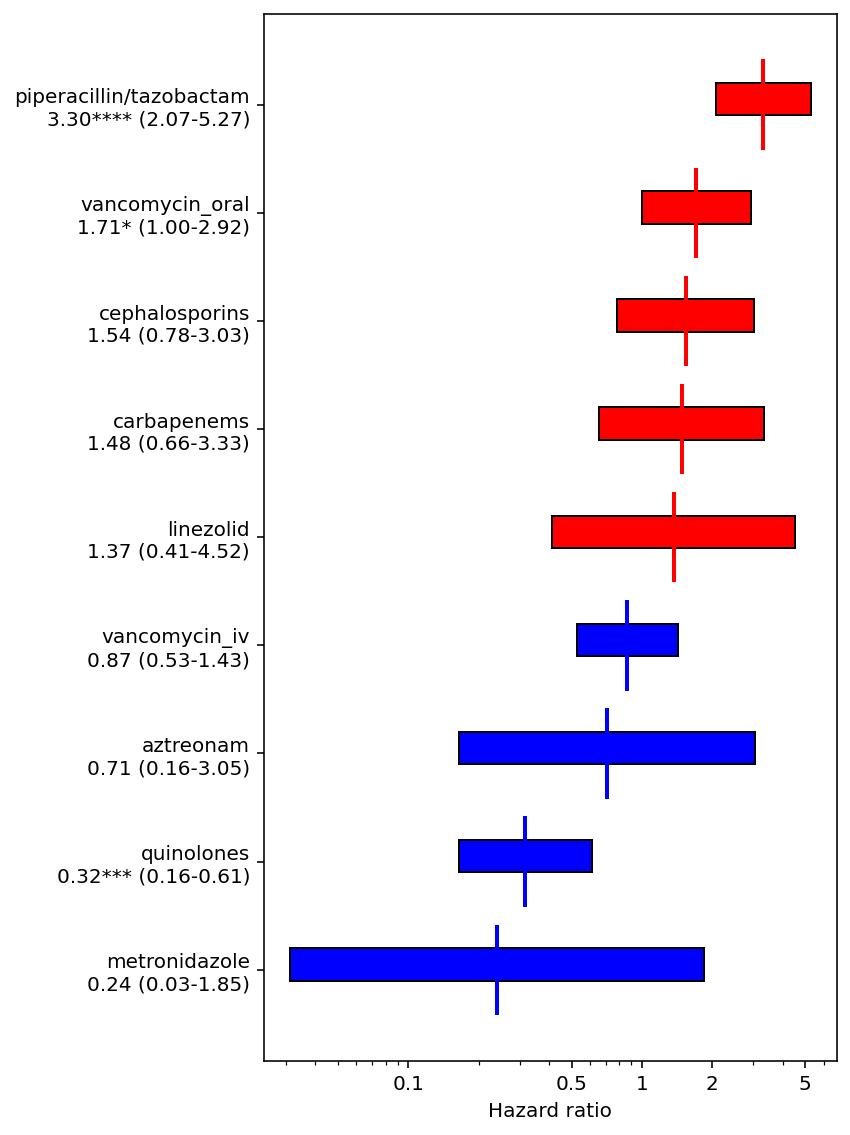

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,8))

yticks = []
yticklabels = []
for k, drug in enumerate(df_cox_summary.index):
    hr = df_cox_summary.loc[drug, 'exp(coef)']
    lower = df_cox_summary.loc[drug, 'exp(coef) lower 95%']
    higher = df_cox_summary.loc[drug, 'exp(coef) upper 95%']
    P = df_cox_summary.loc[drug, 'p']
    
    # create a patch that represent CI
    if hr>1:
        facecolor='r'
    else:
        facecolor='b'
    rect = mpatches.Rectangle((lower, k-0.1), higher-lower, 0.3, linewidth=1, edgecolor='k', facecolor=facecolor)
    _ = ax.add_patch(rect)
    
    # plot HR
    _ = ax.plot([hr, hr],[k-0.4, k+0.4], linewidth=2, color=facecolor)
    
    # create P value notation
    # P < 0.05 *
    # P < 0.01 **
    # P < 0.001 ***
    # P < 0.0001 ****
    Psym = ''
    if P<0.0001:
        Psym = '****'
    elif P<0.001:
        Psym = '***'
    elif P<0.01:
        Psym = '**'
    elif P<0.05:
        Psym = '*'
    
    yticks.append(k)
    yticklabels.append('%s\n%2.2f%s (%2.2f-%2.2f)'%(drug, hr, Psym, lower, higher))

_ = ax.set_yticks(yticks)
_ = ax.set_yticklabels(yticklabels)
_ = ax.set_xlabel('Hazard ratio')
_ = ax.set_xscale('log')
_ = ax.set_xticks([0.1,0.5,1,2,5])
_ = ax.set_xticklabels([0.1,0.5,1,2,5])
#_ = ax.set_xlim([0,14])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("hazard_ratio_antibiotic_oral_association.svg")

# Plot oral bacterial fraction for patients FMT.0083, FMT.0222, FMT.0099, 1261

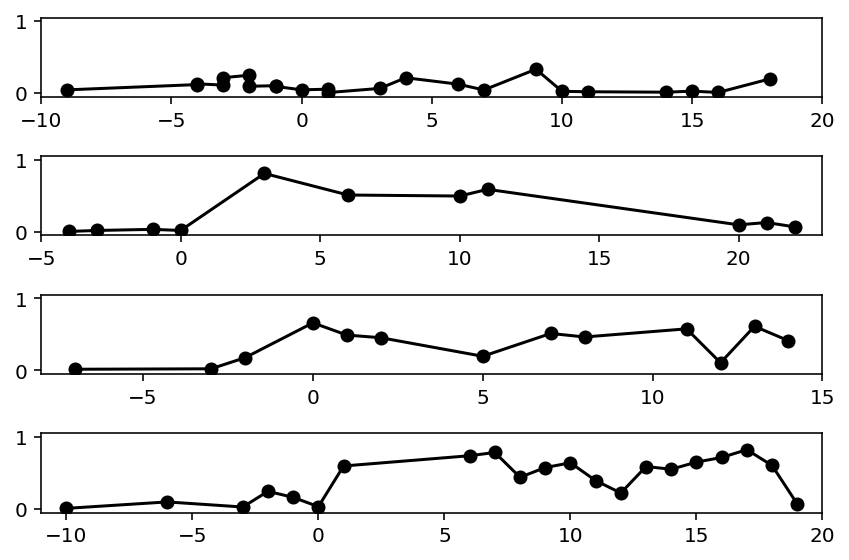

In [31]:
df_oral = df_relab[set(df_relab.columns).intersection(set(df_blast_100.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
df_meta_oral = pd.merge(df_sample, df_oral, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6,4), sharey=True)
for k,pid in enumerate(['FMT.0083','FMT.0222','FMT.0099','1261']):
    curr_df = df_meta_oral[df_meta_oral.PatientID==pid].sort_values('DayRelativeToNearestHCT')
    if k==0:
        curr_df = curr_df[(curr_df.DayRelativeToNearestHCT>=-10) & (curr_df.DayRelativeToNearestHCT<=20)]
        _ =ax[k].plot(curr_df.DayRelativeToNearestHCT, curr_df.OralFrac, 'k-o')
        _ = ax[k].set_xlim([-10,20])
    elif k==1:
        curr_df = curr_df[(curr_df.DayRelativeToNearestHCT>=-5) & (curr_df.DayRelativeToNearestHCT<=23)]
        _ =ax[k].plot(curr_df.DayRelativeToNearestHCT, curr_df.OralFrac, 'k-o')
        _ = ax[k].set_xlim([-5,23])
    elif k==2:
        curr_df = curr_df[(curr_df.DayRelativeToNearestHCT>=-8) & (curr_df.DayRelativeToNearestHCT<=15)]
        _ =ax[k].plot(curr_df.DayRelativeToNearestHCT, curr_df.OralFrac, 'k-o')
        _ = ax[k].set_xlim([-8,15])
    elif k==3:
        curr_df = curr_df[(curr_df.DayRelativeToNearestHCT>=-11) & (curr_df.DayRelativeToNearestHCT<=20)]
        _ =ax[k].plot(curr_df.DayRelativeToNearestHCT, curr_df.OralFrac, 'k-o')
        _ = ax[k].set_xlim([-11,20])
    _ = ax[k].set_ylim([-0.05,1.05])
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("selected_patients_oral_fraction_dynamics.svg", format="svg")